# Google Decimeter Challenge

##### Chad Loh, Michelle Bui, Layal Hammad, Caroline Keough

In [241]:
import numpy as np
import pandas as pd
import pymap3d as pm
import pymap3d.vincenty as pmv
import matplotlib.pyplot as plt
import glob as gl
import scipy.optimize
from tqdm.auto import tqdm
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.spatial import distance
import pyproj as proj
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# Constants
CLIGHT = 299_792_458   # speed of light (m/s)
RE_WGS84 = 6_378_137   # earth semimajor axis (WGS84) (m)
OMGE = 7.2921151467E-5  # earth angular velocity (IS-GPS) (rad/s)

### Satellite Selection

In [4]:
# Satellite selection using carrier frequency error, elevation angle, and C/N0
def satellite_selection(df, column):
    """
    Args:
        df : DataFrame from device_gnss.csv
        column : Column name
    Returns:
        df: DataFrame with eliminated satellite signals
    """
    idx = df[column].notnull()
    idx &= df['CarrierErrorHz'] < 2.0e6         # carrier frequency error (Hz)
    idx &= df['SvElevationDegrees'] > 10.0      # elevation angle (deg)
    idx &= df['Cn0DbHz'] > 15.0                 # C/N0 (dB-Hz)
    idx &= df['MultipathIndicator'] == 0        # Multipath flag

    return df[idx]

### Robust Weighted Least Squares

In [5]:
# GNSS single point positioning using pseudorange
def point_positioning(gnss_df):
    # Add nominal frequency to each signal
    # Note: GLONASS is an FDMA signal, so each satellite has a different frequency
    CarrierFrequencyHzRef = gnss_df.groupby(['Svid', 'SignalType'])[
        'CarrierFrequencyHz'].median()
    gnss_df = gnss_df.merge(CarrierFrequencyHzRef, how='left', on=[
                            'Svid', 'SignalType'], suffixes=('', 'Ref'))
    gnss_df['CarrierErrorHz'] = np.abs(
        (gnss_df['CarrierFrequencyHz'] - gnss_df['CarrierFrequencyHzRef']))

    # Carrier smoothing
    gnss_df = carrier_smoothing(gnss_df)

    # GNSS single point positioning
    utcTimeMillis = gnss_df['utcTimeMillis'].unique()
    nepoch = len(utcTimeMillis)
    x0 = np.zeros(4)  # [x,y,z,tGPSL1]
    v0 = np.zeros(4)  # [vx,vy,vz,dtGPSL1]
    x_wls = np.full([nepoch, 3], np.nan)  # For saving position
    v_wls = np.full([nepoch, 3], np.nan)  # For saving velocity

    # Loop for epochs
    for i, (t_utc, df) in enumerate(tqdm(gnss_df.groupby('utcTimeMillis'), total=nepoch)):
        # Valid satellite selection
        df_pr = satellite_selection(df, 'pr_smooth')
        df_prr = satellite_selection(df, 'PseudorangeRateMetersPerSecond')

        # Corrected pseudorange/pseudorange rate
        pr = (df_pr['pr_smooth'] + df_pr['SvClockBiasMeters'] - df_pr['IsrbMeters'] -
              df_pr['IonosphericDelayMeters'] - df_pr['TroposphericDelayMeters']).to_numpy()
        prr = (df_prr['PseudorangeRateMetersPerSecond'] +
               df_prr['SvClockDriftMetersPerSecond']).to_numpy()

        # Satellite position/velocity
        xsat_pr = df_pr[['SvPositionXEcefMeters', 'SvPositionYEcefMeters',
                         'SvPositionZEcefMeters']].to_numpy()
        xsat_prr = df_prr[['SvPositionXEcefMeters', 'SvPositionYEcefMeters',
                           'SvPositionZEcefMeters']].to_numpy()
        vsat = df_prr[['SvVelocityXEcefMetersPerSecond', 'SvVelocityYEcefMetersPerSecond',
                       'SvVelocityZEcefMetersPerSecond']].to_numpy()

        # Weight matrix for peseudorange/pseudorange rate
        Wx = np.diag(1 / df_pr['RawPseudorangeUncertaintyMeters'].to_numpy())
        Wv = np.diag(1 / df_prr['PseudorangeRateUncertaintyMetersPerSecond'].to_numpy())

        # Robust WLS requires accurate initial values for convergence,
        # so perform normal WLS for the first time
        if len(df_pr) >= 4:
            # Normal WLS
            if np.all(x0 == 0):
                opt = scipy.optimize.least_squares(
                    pr_residuals, x0, jac_pr_residuals, args=(xsat_pr, pr, Wx))
                x0 = opt.x 
            # Robust WLS for position estimation
            opt = scipy.optimize.least_squares(
                 pr_residuals, x0, jac_pr_residuals, args=(xsat_pr, pr, Wx), loss='soft_l1')
            if opt.status < 1 or opt.status == 2:
                 print(f'i = {i} position lsq status = {opt.status}')
            else:
                 x_wls[i, :] = opt.x[:3]
                 x0 = opt.x
                 
        # Velocity estimation
        if len(df_prr) >= 4:
            if np.all(v0 == 0): # Normal WLS
                opt = scipy.optimize.least_squares(
                    prr_residuals, v0, jac_prr_residuals, args=(vsat, prr, x0, xsat_prr, Wv))
                v0 = opt.x
            # Robust WLS for velocity estimation
            opt = scipy.optimize.least_squares(
                prr_residuals, v0, jac_prr_residuals, args=(vsat, prr, x0, xsat_prr, Wv), loss='soft_l1')
            if opt.status < 1:
                print(f'i = {i} velocity lsq status = {opt.status}')
            else:
                v_wls[i, :] = opt.x[:3]
                v0 = opt.x

    return utcTimeMillis, x_wls, v_wls

### Carrier Smoothing

In [6]:
# Carrier smoothing of pseudarange
def carrier_smoothing(gnss_df):
    """
    Args:
        df : DataFrame from device_gnss.csv
    Returns:
        df: DataFrame with carrier-smoothing pseudorange 'pr_smooth'
    """
    carr_th = 1.6 # carrier phase jump threshold [m] 2->1.5 (best)->1.0
    pr_th =  20.0 # pseudorange jump threshold [m] 20->15

    prsmooth = np.full_like(gnss_df['RawPseudorangeMeters'], np.nan)
    # Loop for each signal
    for (i, (svid_sigtype, df)) in enumerate((gnss_df.groupby(['Svid', 'SignalType']))):
        df = df.replace(
            {'AccumulatedDeltaRangeMeters': {0: np.nan}})  # 0 to NaN

        # Compare time difference between pseudorange/carrier with Doppler
        drng1 = df['AccumulatedDeltaRangeMeters'].diff() - df['PseudorangeRateMetersPerSecond']
        drng2 = df['RawPseudorangeMeters'].diff() - df['PseudorangeRateMetersPerSecond']

        # Check cycle-slip
        slip1 = (df['AccumulatedDeltaRangeState'].to_numpy() & 2**1) != 0  # reset flag
        slip2 = (df['AccumulatedDeltaRangeState'].to_numpy() & 2**2) != 0  # cycle-slip flag
        slip3 = np.fabs(drng1.to_numpy()) > carr_th # Carrier phase jump
        slip4 = np.fabs(drng2.to_numpy()) > pr_th # Pseudorange jump

        idx_slip = slip1 | slip2 | slip3 | slip4
        idx_slip[0] = True

        # groups with continuous carrier phase tracking
        df['group_slip'] = np.cumsum(idx_slip)

        # Psudorange - carrier phase
        df['dpc'] = df['RawPseudorangeMeters'] - df['AccumulatedDeltaRangeMeters']

        # Absolute distance bias of carrier phase
        meandpc = df.groupby('group_slip')['dpc'].mean()
        df = df.merge(meandpc, on='group_slip', suffixes=('', '_Mean'))

        # Index of original gnss_df
        idx = (gnss_df['Svid'] == svid_sigtype[0]) & (
            gnss_df['SignalType'] == svid_sigtype[1])

        # Carrier phase + bias
        prsmooth[idx] = df['AccumulatedDeltaRangeMeters'] + df['dpc_Mean']

    # If carrier smoothing is not possible, use original pseudorange
    idx_nan = np.isnan(prsmooth)
    prsmooth[idx_nan] = gnss_df['RawPseudorangeMeters'][idx_nan]
    gnss_df['pr_smooth'] = prsmooth

    return gnss_df

### Pseudorange/Doppler Residuals and Jacobian

In [7]:
# Compute line-of-sight vector from user to satellite
def los_vector(xusr, xsat):
    """
    Args:
        xusr : user position in ECEF (m)
        xsat : satellite position in ECEF (m)
    Returns:
        u: unit line-of-sight vector in ECEF (m)
        rng: distance between user and satellite (m)
    """
    u = xsat - xusr
    rng = np.linalg.norm(u, axis=1).reshape(-1, 1)
    u /= rng
    
    return u, rng.reshape(-1)


# Compute Jacobian matrix
def jac_pr_residuals(x, xsat, pr, W):
    """
    Args:
        x : current position in ECEF (m)
        xsat : satellite position in ECEF (m)
        pr : pseudorange (m)
        W : weight matrix
    Returns:
        W*J : Jacobian matrix
    """
    u, _ = los_vector(x[:3], xsat)
    J = np.hstack([-u, np.ones([len(pr), 1])])  # J = [-ux -uy -uz 1]

    return W @ J


# Compute pseudorange residuals
def pr_residuals(x, xsat, pr, W):
    """
    Args:
        x : current position in ECEF (m)
        xsat : satellite position in ECEF (m)
        pr : pseudorange (m)
        W : weight matrix
    Returns:
        residuals*W : pseudorange residuals
    """
    u, rng = los_vector(x[:3], xsat)

    # Approximate correction of the earth rotation (Sagnac effect) often used in GNSS positioning
    rng += OMGE * (xsat[:, 0] * x[1] - xsat[:, 1] * x[0]) / CLIGHT

    # Add GPS L1 clock offset
    residuals = rng - (pr - x[3])

    return residuals @ W


# Compute Jacobian matrix
def jac_prr_residuals(v, vsat, prr, x, xsat, W):
    """
    Args:
        v : current velocity in ECEF (m/s)
        vsat : satellite velocity in ECEF (m/s)
        prr : pseudorange rate (m/s)
        x : current position in ECEF (m)
        xsat : satellite position in ECEF (m)
        W : weight matrix
    Returns:
        W*J : Jacobian matrix
    """
    u, _ = los_vector(x[:3], xsat)
    J = np.hstack([-u, np.ones([len(prr), 1])])

    return np.dot(W, J)


# Compute pseudorange rate residuals
def prr_residuals(v, vsat, prr, x, xsat, W):
    """
    Args:
        v : current velocity in ECEF (m/s)
        vsat : satellite velocity in ECEF (m/s)
        prr : pseudorange rate (m/s)
        x : current position in ECEF (m)
        xsat : satellite position in ECEF (m)
        W : weight matrix
    Returns:
        residuals*W : pseudorange rate residuals
    """
    u, rng = los_vector(x[:3], xsat)
    rate = np.sum((vsat-v[:3])*u, axis=1) \
          + OMGE / CLIGHT * (vsat[:, 1] * x[0] + xsat[:, 1] * v[0]
                           - vsat[:, 0] * x[1] - xsat[:, 0] * v[1])

    residuals = rate - (prr - v[3])

    return residuals @ W

### Outlier Detection and Interpolation

In [8]:
# Simple outlier detection and interpolation
def exclude_interpolate_outlier(x_wls, v_wls):
    # Up velocity threshold
    v_up_th = 2.0 # m/s

    # Coordinate conversion
    x_llh = np.array(pm.ecef2geodetic(x_wls[:, 0], x_wls[:, 1], x_wls[:, 2])).T
    v_enu = np.array(pm.ecef2enuv(
        v_wls[:, 0], v_wls[:, 1], v_wls[:, 2], x_llh[0, 0], x_llh[0, 1])).T

    # Up velocity jump detection
    # Cars don't jump suddenly!
    idx_v_out = np.abs(v_enu[:, 2]) > v_up_th
    v_wls[idx_v_out, :] = np.nan
    
    # Interpolate NaNs at beginning and end of array
    x_df = pd.DataFrame({'x': x_wls[:, 0], 'y': x_wls[:, 1], 'z': x_wls[:, 2]})
    x_df = x_df.interpolate(limit_area='outside', limit_direction='both')
    
    # Interpolate all NaN data
    v_df = pd.DataFrame({'x': v_wls[:, 0], 'y': v_wls[:, 1], 'z': v_wls[:, 2]})
    v_df = v_df.interpolate(limit_area='outside', limit_direction='both')
    v_df = v_df.interpolate('spline', order=3)

    return x_df.to_numpy(), v_df.to_numpy()

### Kalman Smoother

In [9]:
# Kalman filter
def Kalman_filter(zs, us, phone):
    # Parameters
    # I don't know why only XiaomiMi8 seems to be inaccurate ... 
    sigma_v = 0.6 if phone == 'XiaomiMi8' else 0.1 # velocity SD m/s
    sigma_x = 5.0  # position SD m
    sigma_mahalanobis = 30.0 # Mahalanobis distance for rejecting innovation
    
    n, dim_x = zs.shape
    F = np.eye(3)  # Transition matrix
    Q = sigma_v**2 * np.eye(3)  # Process noise

    H = np.eye(3)  # Measurement function
    R = sigma_x**2 * np.eye(3)  # Measurement noise

    # Initial state and covariance
    x = zs[0, :3].T  # State
    P = sigma_x**2 * np.eye(3)  # State covariance
    I = np.eye(dim_x)

    x_kf = np.zeros([n, dim_x])
    P_kf = np.zeros([n, dim_x, dim_x])

    # Kalman filtering
    for i, (u, z) in enumerate(zip(us, zs)):
        # First step
        if i == 0:
            x_kf[i] = x.T
            P_kf[i] = P
            continue

        # Prediction step
        x = F @ x + u.T
        P = (F @ P) @ F.T + Q

        # Check outliers for observation
        d = distance.mahalanobis(z, H @ x, np.linalg.pinv(P))

        # Update step
        if d < sigma_mahalanobis:
            y = z.T - H @ x
            S = (H @ P) @ H.T + R
            K = (P @ H.T) @ np.linalg.inv(S)
            x = x + K @ y
            P = (I - (K @ H)) @ P
        else:
            # If no observation update is available, increase covariance
            P += 10**2*Q

        x_kf[i] = x.T
        P_kf[i] = P

    return x_kf, P_kf


# Forward + backward Kalman filter and smoothing
def Kalman_smoothing(x_wls, v_wls, phone):
    n, dim_x = x_wls.shape

    # Forward
    v = np.vstack([np.zeros([1, 3]), (v_wls[:-1, :] + v_wls[1:, :])/2])
    x_f, P_f = Kalman_filter(x_wls, v, phone)

    # Backward
    v = -np.flipud(v_wls)
    v = np.vstack([np.zeros([1, 3]), (v[:-1, :] + v[1:, :])/2])
    x_b, P_b = Kalman_filter(np.flipud(x_wls), v, phone)

    # Smoothing
    x_fb = np.zeros_like(x_f)
    P_fb = np.zeros_like(P_f)
    for (f, b) in zip(range(n), range(n-1, -1, -1)):
        P_fi = np.linalg.inv(P_f[f])
        P_bi = np.linalg.inv(P_b[b])

        P_fb[f] = np.linalg.inv(P_fi + P_bi)
        x_fb[f] = P_fb[f] @ (P_fi @ x_f[f] + P_bi @ x_b[b])

    return x_fb, x_f, np.flipud(x_b)

### Train data

In [13]:
path = './data/2021-07-19-US-MTV-1/GooglePixel4'

drive, phone = path.split('/')[-2:]

# Read data
gnss_df = pd.read_csv(f'{path}/device_gnss.csv')  # GNSS data
gt_df = pd.read_csv(f'{path}/ground_truth.csv')  # ground truth

# Point positioning
utc, x_wls, v_wls = point_positioning(gnss_df)

# Exclude velocity outliers
x_wls, v_wls = exclude_interpolate_outlier(x_wls, v_wls)

# Kalman smoothing
x_kf, _, _ = Kalman_smoothing(x_wls, v_wls, phone)

# Convert to latitude and longitude
llh_wls = np.array(pm.ecef2geodetic(x_wls[:, 0], x_wls[:, 1], x_wls[:, 2])).T
llh_kf = np.array(pm.ecef2geodetic(x_kf[:, 0], x_kf[:, 1], x_kf[:, 2])).T

# Baseline
x_bl = gnss_df.groupby('TimeNanos')[
    ['WlsPositionXEcefMeters', 'WlsPositionYEcefMeters', 'WlsPositionZEcefMeters']].mean().to_numpy()
llh_bl = np.array(pm.ecef2geodetic(x_bl[:, 0], x_bl[:, 1], x_bl[:, 2])).T




  0%|          | 0/1896 [00:00<?, ?it/s]

### Score Computation

In [14]:
# Compute distance by Vincenty's formulae
def vincenty_distance(llh1, llh2):
    """
    Args:
        llh1 : [latitude,longitude] (deg)
        llh2 : [latitude,longitude] (deg)
    Returns:
        d : distance between llh1 and llh2 (m)
    """
    d, az = np.array(pmv.vdist(llh1[:, 0], llh1[:, 1], llh2[:, 0], llh2[:, 1]))

    return d


# Compute score
def calc_score(llh, llh_gt):
    """
    Args:
        llh : [latitude,longitude] (deg)
        llh_gt : [latitude,longitude] (deg)
    Returns:
        score : (m)
    """
    d = vincenty_distance(llh, llh_gt)
    score = np.mean([np.quantile(d, 0.50), np.quantile(d, 0.95)])

    return score
    
# Ground truth
llh_gt = gt_df[['LatitudeDegrees', 'LongitudeDegrees']].to_numpy()

# Distance from ground truth
vd_bl = vincenty_distance(llh_bl, llh_gt)
vd_wls = vincenty_distance(llh_wls, llh_gt)
vd_kf = vincenty_distance(llh_kf, llh_gt)

# Score
score_bl = calc_score(llh_bl, llh_gt)
score_wls = calc_score(llh_wls, llh_gt)
score_kf = calc_score(llh_kf[:-1, :], llh_gt[:-1, :])

print(f'Score Baseline   {score_bl:.4f} [m]')
print(f'Score Robust WLS {score_wls:.4f} [m]')
print(f'Score KF         {score_kf:.4f} [m]')

Score Baseline   2.1929 [m]
Score Robust WLS 1.9769 [m]
Score KF         1.1443 [m]


### Plotting

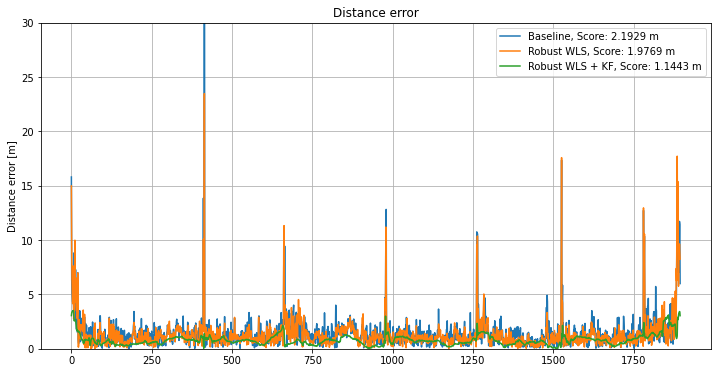

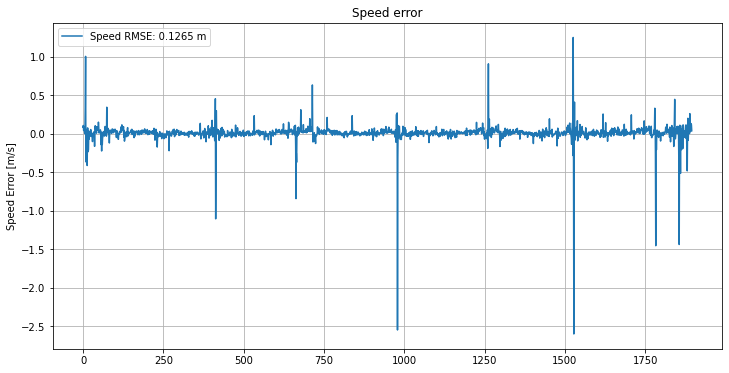

In [17]:
# Plot distance error
plt.figure(figsize=(12,6))
plt.title('Distance error')
plt.ylabel('Distance error [m]')
plt.plot(vd_bl, label=f'Baseline, Score: {score_bl:.4f} m')
plt.plot(vd_wls, label=f'Robust WLS, Score: {score_wls:.4f} m')
plt.plot(vd_kf, label=f'Robust WLS + KF, Score: {score_kf:.4f} m')
plt.legend()
plt.grid()
plt.ylim([0, 30])

# Compute velocity error
speed_wls = np.linalg.norm(v_wls[:, :3], axis=1)
speed_gt = gt_df['SpeedMps'].to_numpy()
speed_rmse = np.sqrt(np.sum((speed_wls-speed_gt)**2)/len(speed_gt))

# Plot velocity error
plt.figure(figsize=(12,6))
plt.title('Speed error')
plt.ylabel('Speed Error [m/s]')
plt.plot(speed_wls - speed_gt, label=f'Speed RMSE: {speed_rmse:.4f} m')
plt.legend()
plt.grid()

### Mapping

In [249]:
llh_bl_df = pd.DataFrame(llh_bl)
llh_wls_df = pd.DataFrame(llh_wls)
llh_kf_df = pd.DataFrame(llh_kf)

gt_df.rename(columns = {'LatitudeDegrees':'lat', 'LongitudeDegrees':'lon'}, inplace = True)

llh_bl_df.columns = ['lat', 'lon', 'Noise']
llh_wls_df.columns = ['lat', 'lon', 'Noise']
llh_kf_df.columns = ['lat', 'lon', 'Noise']

all_tracks = pd.concat([gt_df, llh_bl_df, llh_wls_df, llh_kf_df])
all_tracks  =all_tracks[['lat', 'lon']]
all_tracks['Name'] = np.repeat(['gt','bl', 'wls','kf'],gt_df.shape[0])


In [250]:
import plotly.express as px
import plotly.graph_objects as go
              
fig = px.line_mapbox(all_tracks,
                        # Here, plotly gets, (x,y) coordinates
                        lat="lat",
                        lon="lon",
                        #Here, plotly detects color of series
                        color="Name",
                        labels="Name",
                        zoom=12,
                        center={"lat":37.45, "lon":-122.27},
                        height=600,
                        width=800)
fig = px.scatter_mapbox(all_tracks,
                        # Here, plotly gets, (x,y) coordinates
                        lat="lat",
                        lon="lon",
                        #Here, plotly detects color of series
                        color="Name",
                        labels="Name",
                        zoom=12,
                        center={"lat":37.45, "lon":-122.27},
                        height=600,
                        width=800)
fig.update_layout(mapbox_style='stamen-terrain')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

In [251]:
def convert_wgs_to_utm(lon, lat):
    utm_band = str((math.floor((lon + 180) / 6 ) % 60) + 1)
    if len(utm_band) == 1:
        utm_band = '0'+utm_band
    if lat >= 0:
        epsg_code = '326' + utm_band
    else:
        epsg_code = '327' + utm_band
    return epsg_code


In [260]:
import math
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

def add_distance_speed_angle_curv_diff(df):
    # setup your projections
    utm_code = convert_wgs_to_utm(df['lon'].mean(), df['lat'].mean())
    crs_wgs = proj.Proj(init='epsg:4326') # assuming you're using WGS84 geographic
    crs_utm = proj.Proj(init='epsg:{0}'.format(utm_code))

    # then cast your geographic coordinates to the projected system, e.g.
    x, y = proj.transform(crs_wgs, crs_utm, df['lon'], df['lat'])

    df['x'] = x/1000
    df['y'] = y/1000

    df['y_prev'] = df['y'].shift(1)
    df['y_next'] = df['y'].shift(-1)
    df['x_prev'] = df['x'].shift(1)
    df['x_next'] = df['x'].shift(-1)
    df.loc[0 , 'y_prev'] = df.loc[0 , 'y_next'] 
    df.loc[df.index[-1], 'y_next']= df.loc[df.index[-1], 'y_prev']
    df.loc[0 , 'x_prev'] = df.loc[0 , 'x_next'] 
    df.loc[df.index[-1], 'x_next']= df.loc[df.index[-1], 'x_prev']

    x_t = np.gradient(df['x'])
    y_t = np.gradient(df['y'])

    vel = np.array([ [x_t[i], y_t[i]] for i in range(x_t.size)])
    
    speed = np.sqrt(x_t * x_t + y_t * y_t)
    
    tangent = np.array([1/speed] * 2).transpose() * vel

    ss_t = np.gradient(speed)
    xx_t = np.gradient(x_t)
    yy_t = np.gradient(y_t)
    curvature = (xx_t * y_t - x_t * yy_t) / (x_t * x_t + y_t * y_t)**1.5
    df['curvature']= (xx_t * y_t - x_t * yy_t) / (x_t * x_t + y_t * y_t)**1.5
    
    # Accelaration
    tangent_x = tangent[:, 0]
    tangent_y = tangent[:, 1]

    deriv_tangent_x = np.gradient(tangent_x)
    deriv_tangent_y = np.gradient(tangent_y)

    dT_dt = np.array([ [deriv_tangent_x[i], deriv_tangent_y[i]] for i in range(deriv_tangent_x.size)])

    length_dT_dt = np.sqrt(deriv_tangent_x * deriv_tangent_x + deriv_tangent_y * deriv_tangent_y)

    normal = np.array([1/length_dT_dt] * 2).transpose() * dT_dt

    t_component = np.array([ss_t] * 2).transpose()
    n_component = np.array([curvature*ss_t * ss_t] * 2).transpose()

    accel = pd.DataFrame(t_component * tangent + n_component * normal, columns = ['acc_x', 'acc_y'])
    
    acc = pd.DataFrame(np.sqrt(accel['acc_x'] * accel['acc_x'] + accel['acc_y'] * accel['acc_y']), columns = ['acc'])

    df = pd.concat([df, accel, acc], axis = 1).rename(columns={'0':'acc'})


    return df

In [261]:
llh_kf_df = add_distance_speed_angle_curv_diff(llh_kf_df)
llh_kf_df

,lat,lon,Noise,x,y,y_prev,y_next,x_prev,x_next,curvature,acc_x,acc_y,acc,curve_sigmoid,acc_log,acc_x,acc_y,acc
0,37.444095,-122.232799,2.854150,567.863977,4144.415396,4144.414946,4144.414946,567.863921,567.863921,118.113427,0.000019,0.000185,0.000186,5.058136e-52,-8.587289,0.000019,0.000185,0.000186
1,37.444091,-122.232800,3.414000,567.863921,4144.414946,4144.415396,4144.414873,567.863977,567.863863,364.223091,0.000028,0.000184,0.000186,6.605740e-159,-8.588077,0.000028,0.000184,0.000186
2,37.444090,-122.232801,3.724666,567.863863,4144.414873,4144.414946,4144.414790,567.863921,567.863864,468.121760,0.000037,0.000089,0.000096,4.980844e-204,-9.247838,0.000037,0.000089,0.000096
3,37.444090,-122.232801,3.659456,567.863864,4144.414790,4144.414873,4144.414718,567.863863,567.863868,-2955.266257,-0.000004,0.000032,0.000032,1.000000e+00,-10.353703,-0.000004,0.000032,0.000032
4,37.444089,-122.232801,3.780979,567.863868,4144.414718,4144.414790,4144.414752,567.863864,567.863875,12126.320889,-0.000013,0.000027,0.000030,0.000000e+00,-10.417236,-0.000013,0.000027,0.000030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1891,37.444125,-122.232750,-10.682220,567.868294,4144.418731,4144.418600,4144.418942,567.868195,567.868187,-3146.492251,0.000019,-0.000074,0.000076,1.000000e+00,-9.486123,0.000019,-0.000074,0.000076
1892,37.444127,-122.232751,-10.348774,567.868187,4144.418942,4144.418731,4144.419041,567.868294,567.868175,-1046.339744,0.000027,-0.000058,0.000064,1.000000e+00,-9.656128,0.000027,-0.000058,0.000064
1893,37.444128,-122.232752,-11.146979,567.868175,4144.419041,4144.418942,4144.419024,567.868187,567.868156,-84879.099465,0.000358,0.000690,0.000778,1.000000e+00,-7.159276,0.000358,0.000690,0.000778
1894,37.444128,-122.232752,-11.049652,567.868156,4144.419024,4144.419041,4144.419003,567.868175,567.867475,-108.474203,-0.000312,-0.000008,0.000312,1.000000e+00,-8.073294,-0.000312,-0.000008,0.000312


InvalidIndexError: (slice(None, None, None), None)

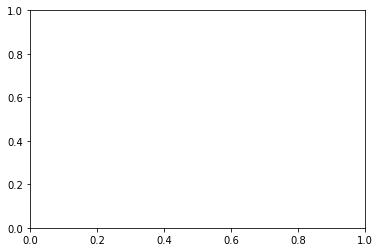

In [267]:
plt.plot(range(llh_kf_df.shape[0]), (llh_kf_df['acc']))
plt.plot(range(llh_kf_df.shape[0]), llh_kf_df['curvature'])

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
llh_kf_df['curve_sigmoid'] = 1/(1+np.exp(llh_kf_df['curvature']))
llh_kf_df['acc_log'] =np.log(llh_kf_df['acc'])


fig = px.scatter_mapbox(llh_kf_df,
                        # Here, plotly gets, (x,y) coordinates
                        lat="lat",
                        lon="lon",
                        #Here, plotly detects color of series
                        color="curve_sigmoid",
                        zoom=12,
                        center={"lat":37.45, "lon":-122.27},
                        height=600,
                        width=800)
fig.update_layout(mapbox_style='stamen-terrain')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.show()

C:\Users\chadd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:397: RuntimeWarning:

overflow encountered in exp



In [266]:
import plotly
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scattermapbox(lon=llh_kf_df['lon'],\
                                        lat=llh_kf_df['lat'],\
                                        marker= go.scattermapbox.Marker(size=9), opacity=0.5,
                                        marker_color=llh_kf_df['acc_log'], name = 'acceleration'),
                      go.Scattermapbox(lon=llh_kf_df['lon'],\
                                        lat=llh_kf_df['lat'],\
                                        marker= go.scattermapbox.Marker(size=9), opacity=0.5,
                                        marker_color=llh_kf_df['curve_sigmoid'], name = 'curvature'),
                                        ])\
        .update_layout(plot_bgcolor='white',autosize=False, width = 1000, height = 800, \
            title_text= 'Map',  \
            legend=dict(x=1.0, y=1)).update_yaxes(showgrid=False).update_xaxes(showgrid=False)

    
fig.update_layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken="pk.eyJ1IjoibGF5YWxoYW1tYWQiLCJhIjoiY2wzbWd5ZWxjMDFqNDNmcWt5MzRzNHdlaCJ9.B04CAbFi5Llmk2B78EP6JQ",
        bearing=0,center=dict(lat=37.45,lon= -122.27),pitch=0,zoom=12.5)
)


fig.show()  